In [1]:
import warnings
warnings.simplefilter('ignore')

import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Load Dataset

In [2]:
def parse_json(data):
    """ function to parse json data """
    session_id = []
    timestamp = []
    cities = []
    user_id = []
    joining_date = []
    country = []
    
    # parse each item
    for item in data:
        session_id.append(item['session_id'][0])
        timestamp.append(item['unix_timestamp'][0])
        cities.append(item['cities'][0])
        user_id.append(item['user'][0][0]['user_id'])
        joining_date.append(item['user'][0][0]['joining_date'])
        country.append(item['user'][0][0]['country'])
    
    # create DataFrame
    maps = {'session_id': session_id, 'timestamp': timestamp, 'cities': cities, 
            'user_id': user_id, 'joining_date': joining_date, 'country': country}
    columns=['session_id', 'timestamp', 'cities', 'user_id', 'joining_date', 'country']
    
    return pd.DataFrame(maps, columns=columns)

In [3]:
with open('./data/city_search.json', 'r') as f:
    json_data = json.load(f)

data = parse_json(json_data)
data['joining_date'] = pd.to_datetime(data['joining_date'])
data.head()

,session_id,timestamp,cities,user_id,joining_date,country
0,X061RFWB06K9V,1442503708,"New York NY, Newark NJ",2024,2015-03-22,UK
1,5AZ2X2A9BHH5U,1441353991,"New York NY, Jersey City NJ, Philadelphia PA",2853,2015-03-28,DE
2,SHTB4IYAX4PX6,1440843490,San Antonio TX,10958,2015-03-06,UK
3,JBRB8MZGTX3M4,1427268063,Edmonton AB,7693,2015-03-12,IT
4,YJCMPURC2FL9C,1430559067,"Phoenix AZ, Houston TX",7506,2015-02-28,UK


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20022 entries, 0 to 20021
Data columns (total 6 columns):
session_id      20022 non-null object
timestamp       20022 non-null int64
cities          20022 non-null object
user_id         20022 non-null int64
joining_date    20022 non-null datetime64[ns]
country         20022 non-null object
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 938.6+ KB


In [5]:
print('Unique session:\t', len(data['session_id'].unique()))
print('Unique users \t', len(data['user_id'].unique()))

Unique session:	 20022
Unique users 	 5777


# Questions

### Question 1
There was a bug in the code and one country didn't get logged. It just shows up as an empty field (""). Can you guess which country was that? How?

In [6]:
# check the value country
data['country'].value_counts().reset_index().rename(columns={'index': 'country', 'country': 'count'})

,country,count
0,US,3876
1,DE,3638
2,UK,3555
3,,2820
4,FR,2298
5,ES,1953
6,IT,1882


Given the current dataset, since there are little information about the dataset, one information that could be used to guess the country is the search time. Since people in different countries will search in similar local time, we can use this information to guess the country.

In [7]:
# extract search time information
data['time'] = pd.to_datetime(data['timestamp'], unit='s')
data['hour'] = data['time'].apply(lambda x: x.hour)

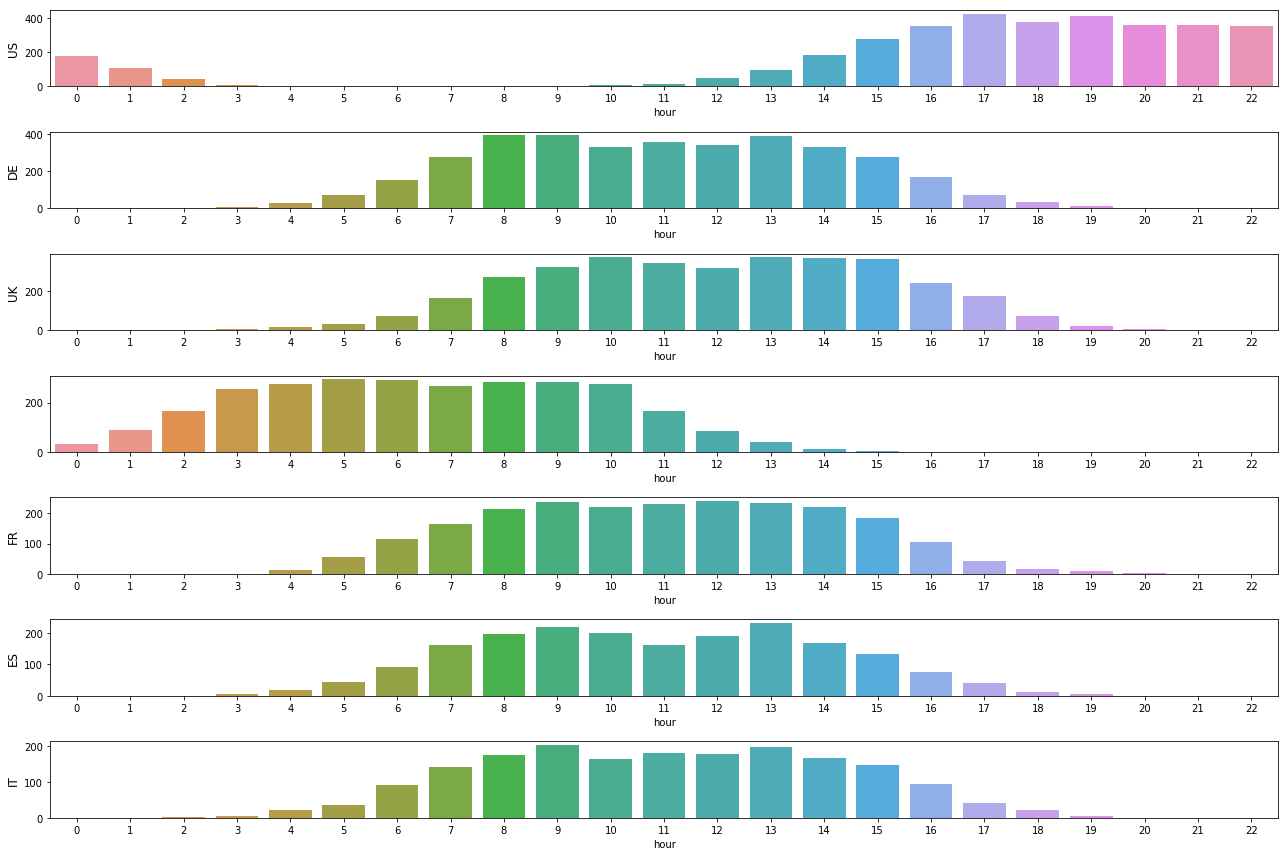

In [8]:
# visualization
country_list = ['US', 'DE', 'UK', '', 'FR', 'ES', 'IT']
order = list(range(0, 23))
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(18, 12))
for i in range(len(country_list)):
    sns.countplot(x='hour', data=data[data['country'] == country_list[i]], ax=ax[i], order=order)
    ax[i].set_ylabel(country_list[i], fontsize=12)
plt.tight_layout()
plt.show()

Based on above figure, we can see that, for the unknown country, their peak search time has around 12 hours difference with United States, and around 5 hours difference with Europe. Based on the geographic locations of each country, it seems that this missing country is in `Asia`. Possible countries include `China` and `Japan`. 

### Question 2
For each city, find the most likely city to be also searched for within the same session.

In [9]:
data.head()

,session_id,timestamp,cities,user_id,joining_date,country,time,hour
0,X061RFWB06K9V,1442503708,"New York NY, Newark NJ",2024,2015-03-22,UK,2015-09-17 15:28:28,15
1,5AZ2X2A9BHH5U,1441353991,"New York NY, Jersey City NJ, Philadelphia PA",2853,2015-03-28,DE,2015-09-04 08:06:31,8
2,SHTB4IYAX4PX6,1440843490,San Antonio TX,10958,2015-03-06,UK,2015-08-29 10:18:10,10
3,JBRB8MZGTX3M4,1427268063,Edmonton AB,7693,2015-03-12,IT,2015-03-25 07:21:03,7
4,YJCMPURC2FL9C,1430559067,"Phoenix AZ, Houston TX",7506,2015-02-28,UK,2015-05-02 09:31:07,9


For this question, we will create a matrix that calculate the city-city similarity.

In [10]:
# find unique cities
city_pair = data['cities'].apply(lambda x: x.split(', '))

index = 0
maps = {}
city_list = []
for item in city_pair:
    for city in item:
        if city not in maps:
            maps[city] = index
            index += 1
            city_list.append(city)
            
print('Unique cities:\t', len(city_list))

Unique cities:	 89


In [11]:
# calculate matrix similarity
pair_matrix = np.zeros((89, 89))

for item in city_pair:
    if len(item) == 1:
        continue
    for i in range(len(item) - 1):
        index1 = maps[item[i]]
        for j in range(i + 1, len(item)):
            index2 = maps[item[j]]
            pair_matrix[index1, index2] += 1
            pair_matrix[index2, index1] += 1

In [12]:
# create dataframe
df_similarity = pd.DataFrame(pair_matrix, index=city_list, columns=city_list)
df_similarity.head()

,New York NY,Newark NJ,Jersey City NJ,Philadelphia PA,San Antonio TX,Edmonton AB,Phoenix AZ,Houston TX,San Diego CA,Montreal QC,...,Birmingham AL,Nashville TN,Omaha NE,Kansas City MO,Raleigh NC,Greensboro NC,New Orleans LA,Charlotte NC,Lincoln NE,Memphis TN
New York NY,0.0,435.0,549.0,428.0,58.0,39.0,63.0,193.0,60.0,315.0,...,0.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0
Newark NJ,435.0,0.0,249.0,230.0,0.0,0.0,0.0,0.0,0.0,16.0,...,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0
Jersey City NJ,549.0,249.0,0.0,201.0,0.0,0.0,0.0,0.0,0.0,17.0,...,0.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0
Philadelphia PA,428.0,230.0,201.0,0.0,0.0,0.0,0.0,13.0,0.0,33.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
San Antonio TX,58.0,0.0,0.0,0.0,0.0,0.0,0.0,143.0,0.0,21.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


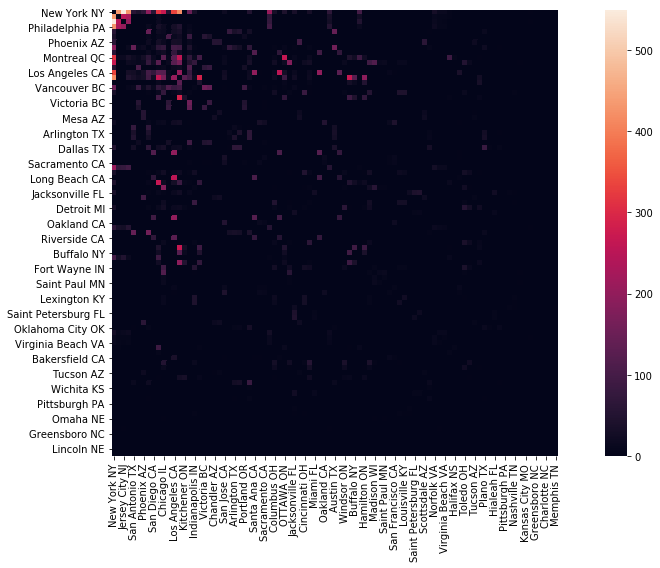

In [13]:
# visualization
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_similarity, ax=ax)
ax.axis('image')
plt.tight_layout()
plt.show()

In [14]:
# get result
result = df_similarity.apply(np.argmax, axis=0).reset_index()
result = result.rename(columns={'index': 'city', 0: 'most similar'})
result

,city,most similar
0,New York NY,Jersey City NJ
1,Newark NJ,New York NY
2,Jersey City NJ,New York NY
3,Philadelphia PA,New York NY
4,San Antonio TX,Houston TX
5,Edmonton AB,Calgary AB
6,Phoenix AZ,Glendale AZ
7,Houston TX,New York NY
8,San Diego CA,Santa Ana CA
9,Montreal QC,New York NY


There is another version of solution that use user instead of session to calculate the similarity. Reference: [Link](https://github.com/stasi009/TakeHomeDataChallenges/blob/master/13.CitySimilarity/city_search.ipynb)

### Question 3
Travel sites are browsed by two kinds of users. Users who are actually planning a trip and users who just dream about a vacation. The first ones have obviously a much higher purchasing intent. Users planning a trip often search for cities close to each other, while users who search for cities far away from each other are often just dreaming about a vacation. That is, a user searching for LA, SF and Las Vegas in the same session is much more likely to book a hotel than a user searching for NY, Paris, Kuala Lumpur (makes sense, right?). Based on this idea, come up with an algorithm that clusters sessions into two groups: high intent and low intent. Explain all assumptions you make along the way.

For this question, one way is to actually calculate the geographic distance for actual searched cities. However, this solution is not very practical for this small project. Another choice is to calculate the distance based on the city-city similarity in Question 2.

In [15]:
def search_distance(cities):
    cities = cities.split(', ')
    
    if len(cities) == 1:
        return 0  # user only search one city, distance 0
    
    distance = 0
    for i in range(len(cities) - 1):
        city1 = cities[i]
        for j in range(i + 1, len(cities)):
            city2 = cities[j]
            distance += df_similarity.loc[city1, city2]
            
    return distance / len(cities)

# calculate distance
data['distance'] = data['cities'].apply(search_distance)

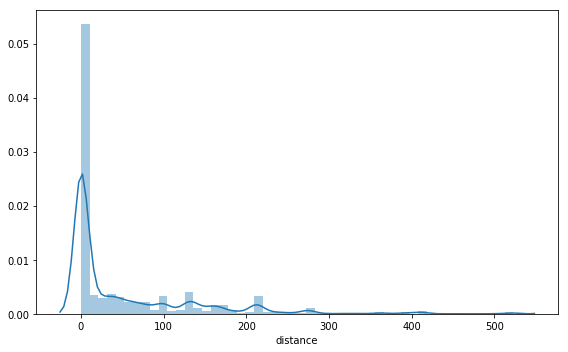

In [16]:
# visualization
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(figsize=(8, 5))
sns.distplot(data['distance'], ax=ax, bins=50)
plt.tight_layout()
plt.show()

It seems that we can set some `threshold` to cut the search `distance` such that any search that is above the threshold are assumed to be the search with `low intent`

There is another solution, for reference, please refer to [Link](https://github.com/stasi009/TakeHomeDataChallenges/blob/master/13.CitySimilarity/city_search.ipynb)